In [1]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
import torch
import torch.nn as nn
import math

def sinusoidal_time_embedding(timesteps, dim):
    """
    timesteps: (B,)
    dim: embedding dimension
    returns: (B, dim)
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(10000) * torch.arange(0, half, dtype=torch.float32) / half
    ).to(timesteps.device)

    args = timesteps[:, None] * freqs[None]
    return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)


In [3]:
class Double_Conv(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.ReLU(inplace=True)

        self.time_mlp = nn.Linear(time_emb_dim, out_ch)


    def forward(self, x, t_emb=None):
        x = self.act(self.conv1(x))

        if t_emb is not None:
            t_added = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
            x = x + t_added

        x = self.act(self.conv2(x))
        return x


In [27]:
class UNet(nn.Module):
    def __init__(self, num_ch, time_emb_dim=256):
        super().__init__()

        self.time_emb_dim = time_emb_dim

        # MLP for timestep embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.ReLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim),
        )

        # Contracting path with time embedding
        self.down_convolution_1 = Double_Conv(num_ch, 64, time_emb_dim)
        self.down_convolution_2 = Double_Conv(64, 128, time_emb_dim)
        self.down_convolution_3 = Double_Conv(128, 256, time_emb_dim)
        self.down_convolution_4 = Double_Conv(256, 512, time_emb_dim)
        self.down_convolution_5 = Double_Conv(512, 1024, time_emb_dim)

        self.max_pool2d = nn.MaxPool2d(2, 2)

        # Expanding path
        self.up_transpose_1 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.up_convolution_1 = Double_Conv(1024, 512, time_emb_dim)

        self.up_transpose_2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.up_convolution_2 = Double_Conv(512, 256, time_emb_dim)

        self.up_transpose_3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up_convolution_3 = Double_Conv(256, 128, time_emb_dim)

        self.up_transpose_4 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up_convolution_4 = Double_Conv(128, 64, time_emb_dim)

        self.out = nn.Conv2d(64, num_ch, 1)

    def forward(self, x, t):
        # ---- time embedding ----
        t_emb = sinusoidal_time_embedding(t, self.time_emb_dim)
        t_emb = self.time_mlp(t_emb)

        # ---- UNet ----
        down_1 = self.down_convolution_1(x, t_emb)
        down_2 = self.max_pool2d(down_1)

        down_3 = self.down_convolution_2(down_2, t_emb)
        down_4 = self.max_pool2d(down_3)

        down_5 = self.down_convolution_3(down_4, t_emb)
        down_6 = self.max_pool2d(down_5)

        down_7 = self.down_convolution_4(down_6, t_emb)
        down_8 = self.max_pool2d(down_7)

        down_9 = self.down_convolution_5(down_8, t_emb)
        # (NO pooling)

        # ---- upward ----
        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1), t_emb)

        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1), t_emb)

        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1), t_emb)

        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1), t_emb)

        return self.out(x)


In [30]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transform
from torchvision.datasets import CIFAR10

batch_size = 64

transform = transform.Compose([
    transform.ToTensor(),
])

train_ds = CIFAR10(root='data', train=True, download=True, transform=transform)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Example: get one batch and shapes
images, labels = next(iter(train_dl))
print(images.shape)  # -> [batch_size, 3, 16, 16]
print(labels.shape)  # -> [batch_size]

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [31]:
T = 50
beta_list= torch.linspace(0.0001, 0.2, steps=T).to(device)
sigma_list = 1 - beta_list

In [32]:
epochs = 100
batch_size = 64
learning_rate = 0.001
# instantiate UNet for single-channel output
model = UNet(num_ch=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fct = torch.nn.MSELoss()

def train_2d(epochs, dataloader, model, optimizer, loss_fct, T, sigma_list, device):
    """Train on MNIST images (tensors shape [B,1,16,16]).
    sigma_list: length-T sequence (torch tensor or numpy array) of per-step alpha/sigma factors.
    The model is expected to predict the noise given noisy image x_t."""
    model.train()

    # ensure sigma_list is a torch tensor on the right device
    if not torch.is_tensor(sigma_list):
        sigma_list = torch.tensor(sigma_list, dtype=torch.float32, device=device)
    else:
        sigma_list = sigma_list.to(device).float()

    # alpha_bar (cumulative product) computed with torch (works on CUDA tensors)
    alpha_bar = torch.cumprod(sigma_list, dim=0)  # shape [T]

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for x0, _labels in dataloader:           # x0 : [B,1,16,16]
            x0 = x0.to(device)

            B = x0.size(0)
            # sample times t in {1,..,T} for each sample
            t = torch.randint(1, T + 1, (B,), device=device, dtype=torch.long)

            # gather alpha_bar for each sampled t and reshape for broadcasting
            alpha_bar_t = alpha_bar[t - 1].view(B, 1, 1, 1)   # [B,1,1,1]

            # sample gaussian noise
            noise = torch.randn_like(x0, device=device)

            # construct noisy image x_t
            x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1.0 - alpha_bar_t) * noise

            optimizer.zero_grad()

            # model predicts the noise (shape [B,1,16,16])
            predicted_noise = model(x_t, t)

            loss = loss_fct(noise, predicted_noise)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / (num_batches if num_batches > 0 else 1)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

train_2d(epochs, train_dl, model, optimizer, loss_fct, T, sigma_list, device)

Epoch [1/100], Loss: 0.0985
Epoch [10/100], Loss: 0.4799
Epoch [20/100], Loss: 0.1376
Epoch [30/100], Loss: 0.0649
Epoch [40/100], Loss: 0.0509
Epoch [50/100], Loss: 0.0466
Epoch [60/100], Loss: 0.0455
Epoch [70/100], Loss: 0.0427
Epoch [80/100], Loss: 0.0437
Epoch [90/100], Loss: 0.0426
Epoch [100/100], Loss: 0.0412


In [33]:
def generate_samples_corrected(model, num_samples, T, device):
    """Génère des échantillons en inversant le processus de diffusion"""
    model.eval()
    
    # Commencer avec du bruit pur
    x_t = torch.randn(num_samples, 3, 32, 32).to(device)
    
    generated_samples = []
    sigma_bar_list = torch.cumprod(sigma_list, dim=0)
    
    with torch.no_grad():
        # Processus de débruitage de T vers 0
        for t in reversed(range(1, T + 1)):
            # Créer un tensor temps pour tous les échantillons
            t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
            
            # Prédire le bruit
            predicted_noise = model(x_t, t_tensor)
            beta_t = beta_list[t - 1]
            sigma_t= sigma_list[t - 1]
            sigma_bar_t = sigma_bar_list[t - 1]
            z= torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
            # Calculer x_{t-1}
            x_t = (1 / torch.sqrt(sigma_t)) * (x_t - (1-sigma_t)/torch.sqrt(1 - sigma_bar_t) * predicted_noise)+  torch.sqrt(beta_t) * z
            # Stocker les échantillons intermédiaires pour visualisation
            generated_samples.append(x_t.cpu().numpy())
    
    return x_t, generated_samples

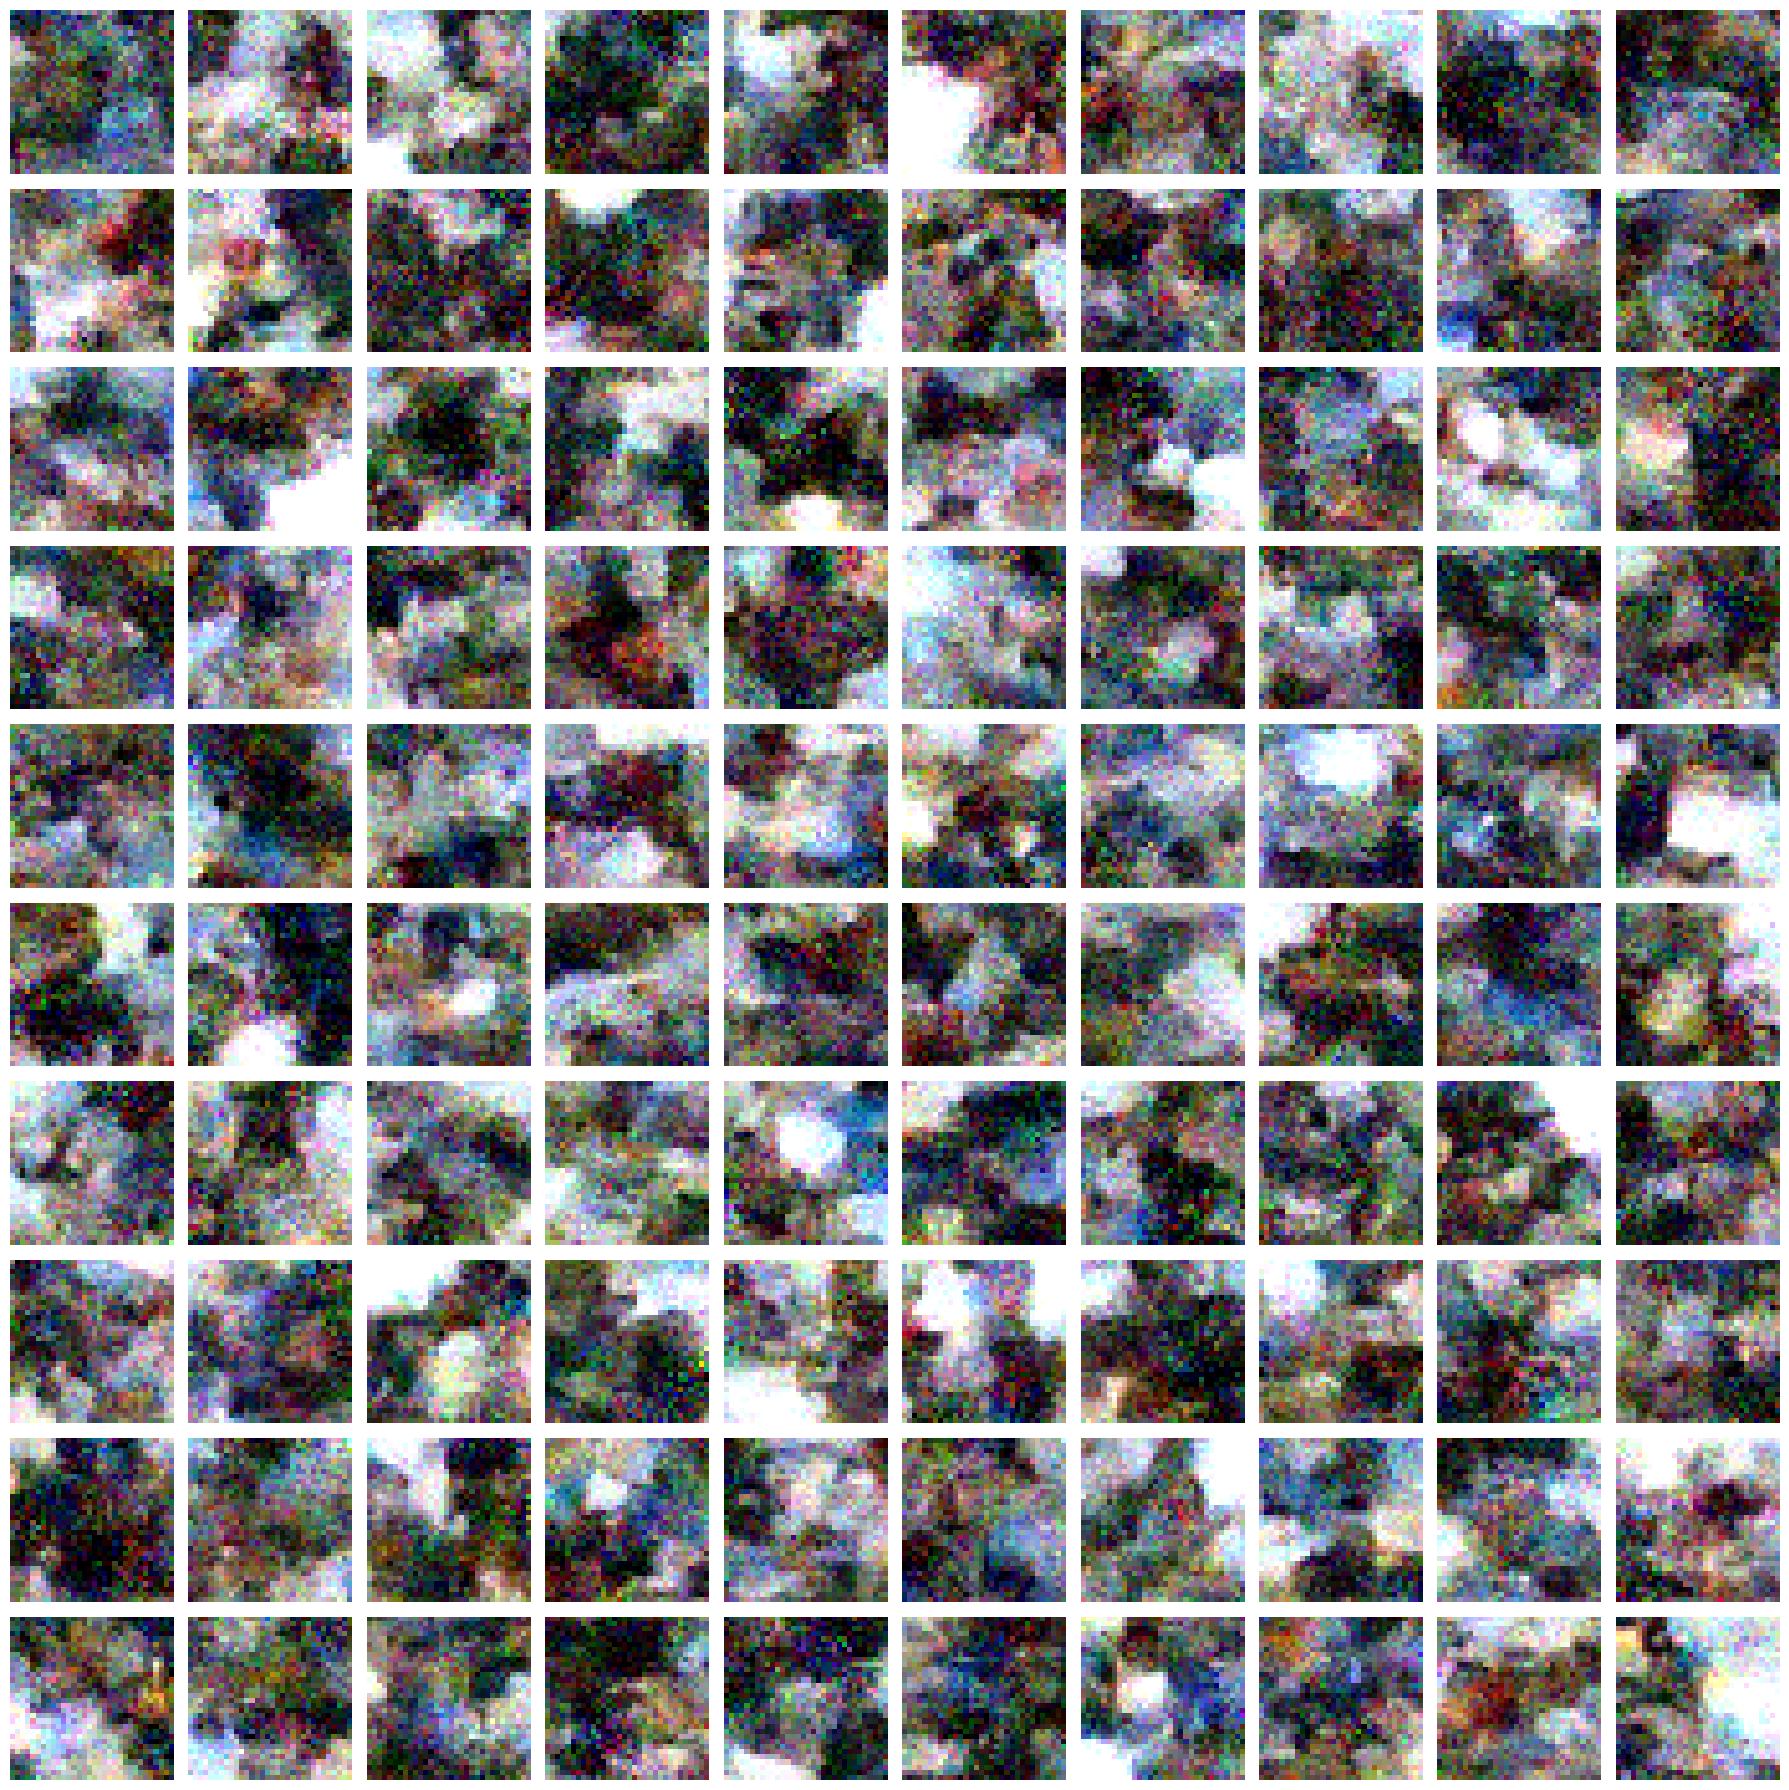

In [35]:
# ...existing code...
import matplotlib.pyplot as plt
import math
%matplotlib inline
num_samples = 100
# generate
final_x_t, intermediates = generate_samples_corrected(model, num_samples, T, device)

# --- prepare final images (all samples) ---
if torch.is_tensor(final_x_t):
    final_imgs = final_x_t.detach().cpu().clamp(0.0, 1.0).squeeze(1).numpy()  # [N,H,W]
else:
    final_imgs = np.array(final_x_t)
N = final_imgs.shape[0]

# display all final images in a grid
cols = min(10, N)
rows = math.ceil(N / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*1.8, rows*1.8))
axes = axes.flatten()
for i in range(rows*cols):
    ax = axes[i]
    if i < N:
        ax.imshow(final_imgs[i].transpose(1, 2, 0), vmin=0, vmax=1)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import os
def save_checkpoint(path, model, optimizer=None, epoch=None, beta_min=None,beta_max=None):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    payload = {'model_state_dict': model.state_dict()}
    if optimizer is not None:
        payload['optimizer_state_dict'] = optimizer.state_dict()
    if epoch is not None:
        payload['epoch'] = epoch
    if beta_min is not None:
        payload['beta_min'] = beta_min
    if beta_max is not None:
        payload['beta_max'] = beta_max

    torch.save(payload, path)

def load_checkpoint(path, model, optimizer=None, device='cpu'):
    chk = torch.load(path, map_location=device)
    model.load_state_dict(chk['model_state_dict'])
    if optimizer is not None and 'optimizer_state_dict' in chk:
        optimizer.load_state_dict(chk['optimizer_state_dict'])
    epoch = chk.get('epoch', None)
    beta_min = chk.get('beta_min', None)
    beta_max = chk.get('beta_max', None)
    return model, optimizer, epoch, beta_min, beta_max
save_checkpoint('checkpoints/unet_cifar10.pt', model, optimizer=optimizer, epoch=100, beta_min=beta_list[0], beta_max=beta_list[-1])